In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
data = pd.read_csv("C:\\Users\\Administrator\\Downloads\AirPassengers (1).csv")
print(data)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [3]:
#Parse strings to datetime type
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format=True) 
#convert from string to datetime
idxData = data.set_index(['Month'])
print(idxData)

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns]


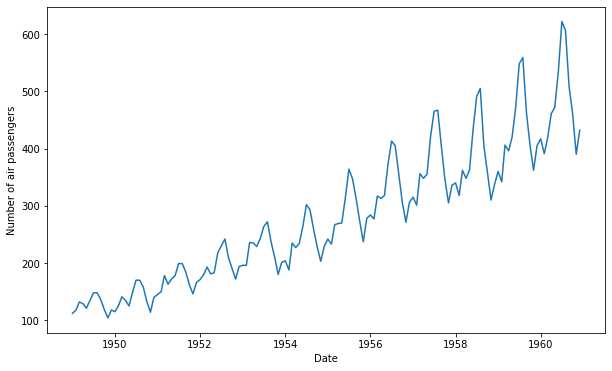

In [4]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(idxData)

In [5]:
#Determine rolling statistics
rolmean = idxData.rolling(window=12).mean() 
#window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = idxData.rolling(window=12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


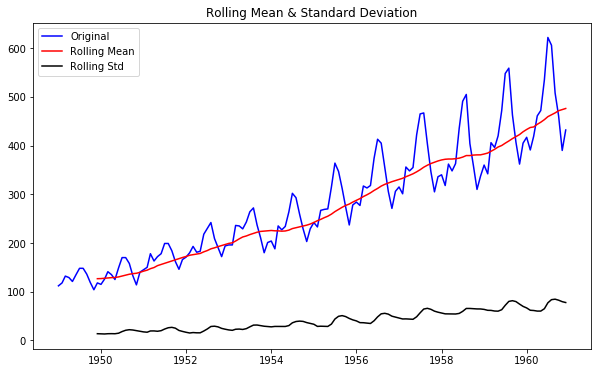

In [6]:
#Plot rolling statistics
orig = plt.plot(idxData, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(idxData['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


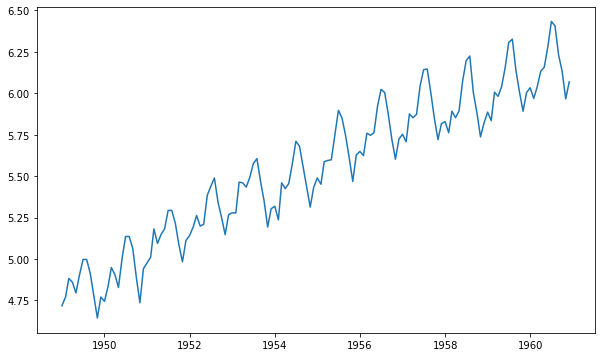

In [8]:
#Estimating trend
logScale = np.log(idxData)
plt.plot(logScale)

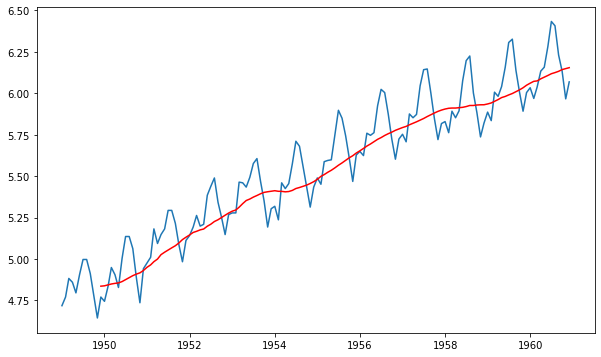

In [9]:
#The below transformation is required to make series stationary
movingAverage = logScale.rolling(window=12).mean()
movingSTD = logScale.rolling(window=12).std()
plt.plot(logScale)
plt.plot(movingAverage, color='red')

In [10]:
detrend = logScale - movingAverage
detrend.head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [11]:
#Remove NAN values
detrend.dropna(inplace=True)
detrend.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [12]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

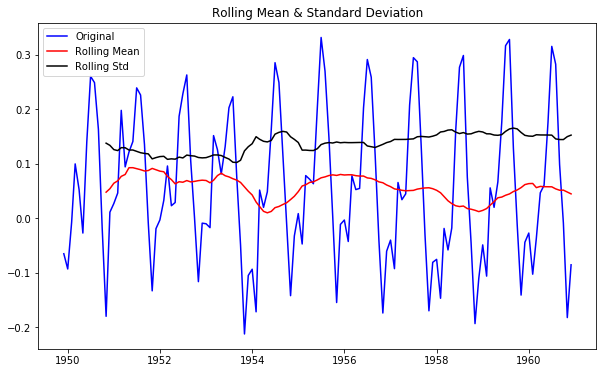

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
test_stationarity(detrend)

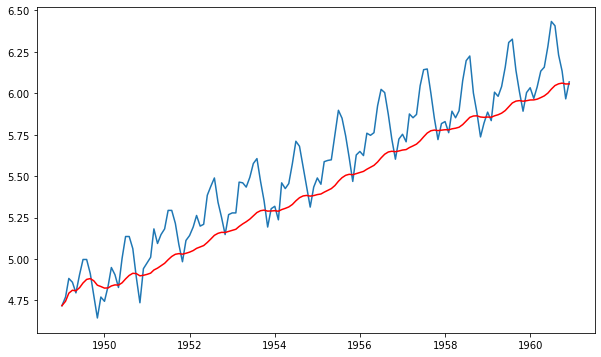

In [14]:
##Transforming with exponential decay####
expdecay = logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(logScale)
plt.plot(expdecay, color='red')

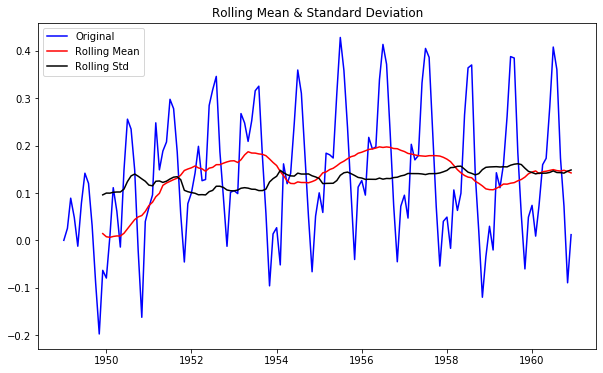

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
detrendexp = logScale - expdecay
test_stationarity(detrendexp)

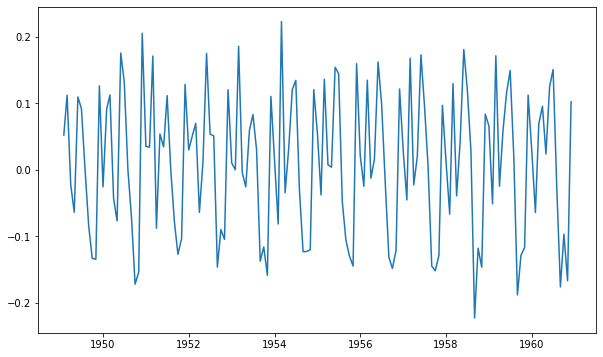

In [16]:
##Time shift transformation###
datadiff = logScale - logScale.shift()
plt.plot(datadiff)

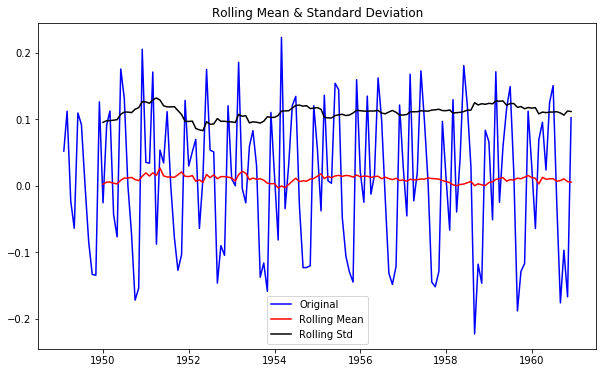

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
datadiff.dropna(inplace=True)
test_stationarity(datadiff)

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


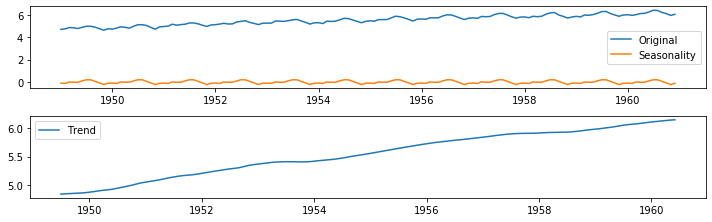

In [18]:
decomposition = seasonal_decompose(logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal

plt.subplot(411)
plt.plot(logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.tight_layout()

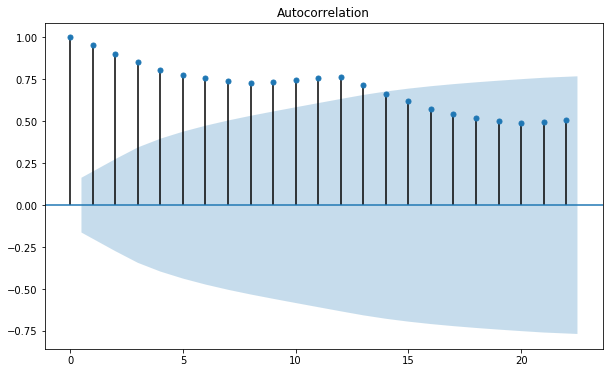

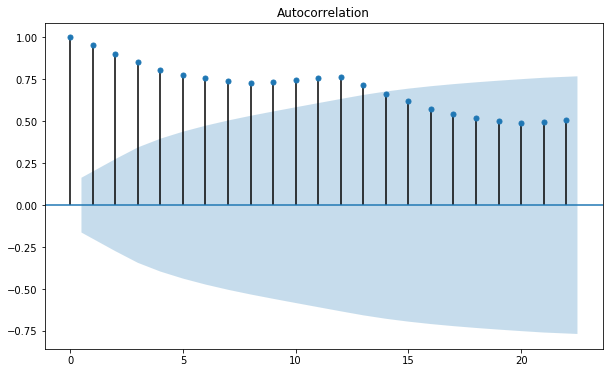

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(logScale)

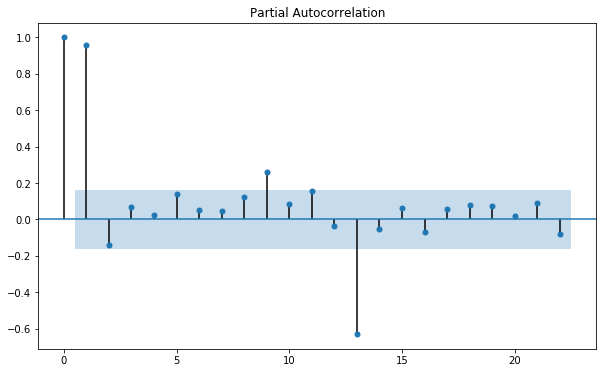

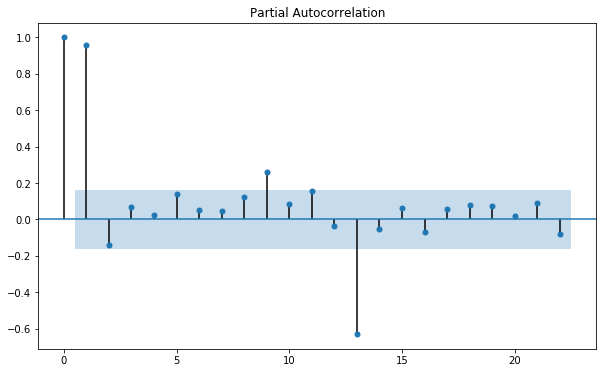

In [20]:
plot_pacf(logScale)

C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


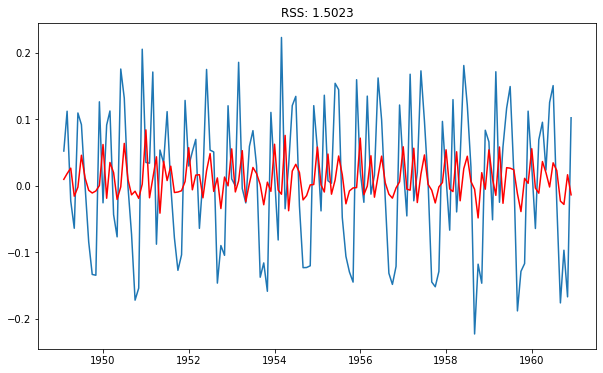

In [21]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datadiff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datadiff['#Passengers'])**2))
print('Plotting AR model')

In [22]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 122.802
Method:                       css-mle   S.D. of innovations              0.102
Date:                Wed, 16 Sep 2020   AIC                           -237.605
Time:                        20:38:35   BIC                           -225.753
Sample:                    02-01-1949   HQIC                          -232.789
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.009      1.048      0.295      -0.008       0.028
ar.L1.D.#Passengers     0.2359      0.083      2.855      0.004       0.074       0.398
ar.L2.D.#Passeng

C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


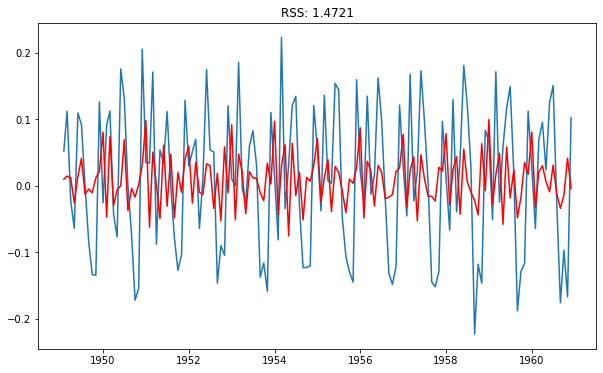

In [23]:
#MA Model
model = ARIMA(logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datadiff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datadiff['#Passengers'])**2))
print('Plotting MA model')

In [25]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 124.189
Method:                       css-mle   S.D. of innovations              0.101
Date:                Wed, 16 Sep 2020   AIC                           -240.379
Time:                        20:40:31   BIC                           -228.528
Sample:                    02-01-1949   HQIC                          -235.563
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.007      1.314      0.189      -0.005       0.024
ma.L1.D.#Passengers     0.2019      0.120      1.688      0.091      -0.033       0.436
ma.L2.D.#Passeng